In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import pennylane as qml
import matplotlib.pyplot as plt

In [2]:
def get_dataset(digits=[3, 5, 8, 9], n_px=16, train_size=1000, test_size=200):
    mnist_train = datasets.MNIST(root='./data', train=True, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True)

    def prepare(data, targets, digits, size, n_px):
        mask = torch.zeros_like(targets, dtype=torch.bool)
        for d in digits:
            mask |= (targets == d)
        data_f = data[mask]
        targ_f = targets[mask]
        idx = torch.randperm(len(data_f))[:size]
        imgs = data_f[idx].unsqueeze(1).float() / 255.0
        labs = targ_f[idx]
        imgs_resized = F.interpolate(imgs, size=(n_px, n_px), mode='bilinear', align_corners=False)
        labs_mapped = torch.tensor([digits.index(int(l)) for l in labs])
        return imgs_resized, labs_mapped

    x_train, y_train = prepare(mnist_train.data, mnist_train.targets, digits, train_size, n_px)
    x_test, y_test = prepare(mnist_test.data, mnist_test.targets, digits, test_size, n_px)
    return (x_train, y_train), (x_test, y_test)

def visualize_data(x, y, pred=None):
    n_img = len(x)
    fig, axes = plt.subplots(1, n_img, figsize=(2*n_img, 2))
    for i in range(n_img):
        axes[i].imshow(x[i], cmap="gray")
        if pred is None:
            axes[i].set_title(f"Label: {y[i]}")
        else:
            axes[i].set_title(f"Label: {y[i]}, Pred: {pred[i]}")
    plt.tight_layout(w_pad=2)

In [3]:
# ---- Configuration ----
digits = [3, 5, 8, 9]
n_px = 16
n_qubits = 8  # small enough for simulation
n_q_layers = 32
num_classes = len(digits)
epochs = 30
batch_size = 64
lr = 0.03


In [4]:
# ---- Load and Prepare Data ----
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px, train_size=10000, test_size=2000)
x_train = x_train.view(x_train.shape[0], -1)
x_test = x_test.view(x_test.shape[0], -1)

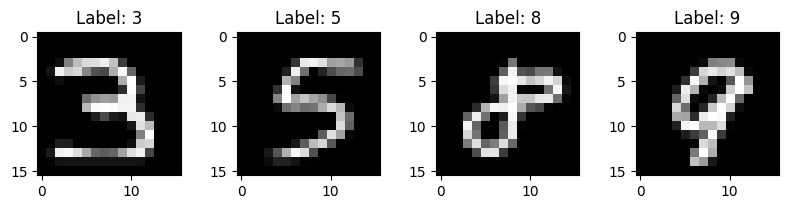

In [5]:
# Visualize
x_vis = [(x_train[y_train == i])[0].reshape(n_px, n_px) for i in range(num_classes)]
visualize_data(x_vis, digits)

In [6]:
# ---- Define Quantum Layer ----
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_q_layers, n_qubits, 3)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="backprop")
quantum_layer = qml.qnn.TorchLayer(qnode, weight_shapes)


In [7]:
# ---- Hybrid Model ----
class QuantumHybridModel(nn.Module):
    def __init__(self, input_dim, n_qubits, num_classes):
        super().__init__()
        self.encoder = nn.Linear(input_dim, n_qubits)  # reduce to n_qubits
        self.q_layer = quantum_layer
        self.classifier = nn.Linear(n_qubits, num_classes)  # final logits

    def forward(self, x):
        x = self.encoder(x)
        x = self.q_layer(x)
        return self.classifier(x)  # return logits directly

In [8]:
# ---- Training ----
model = QuantumHybridModel(input_dim=n_px * n_px, n_qubits=n_qubits, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

def train(model, x_train, y_train, x_test, y_test, epochs, batch_size):
    for epoch in range(epochs):
        model.train()
        idx = torch.randperm(x_train.shape[0])[:batch_size]
        x_batch, y_batch = x_train[idx], y_train[idx]

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            test_logits = model(x_test)
            acc = (torch.argmax(test_logits, dim=1) == y_test).float().mean()
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

train(model, x_train, y_train, x_test, y_test, epochs=epochs, batch_size=batch_size)

Epoch 1 | Loss: 1.3849 | Test Acc: 0.2910
Epoch 2 | Loss: 1.3792 | Test Acc: 0.3295
Epoch 3 | Loss: 1.3438 | Test Acc: 0.5120
Epoch 4 | Loss: 1.2614 | Test Acc: 0.6595
Epoch 5 | Loss: 1.2241 | Test Acc: 0.5975
Epoch 6 | Loss: 1.2043 | Test Acc: 0.6810
Epoch 7 | Loss: 1.1208 | Test Acc: 0.7735
Epoch 8 | Loss: 1.1493 | Test Acc: 0.8035
Epoch 9 | Loss: 0.9892 | Test Acc: 0.7915
Epoch 10 | Loss: 0.9406 | Test Acc: 0.7580
Epoch 11 | Loss: 0.9952 | Test Acc: 0.7820
Epoch 12 | Loss: 0.9301 | Test Acc: 0.7850
Epoch 13 | Loss: 0.9429 | Test Acc: 0.8355
Epoch 14 | Loss: 0.9357 | Test Acc: 0.8755
Epoch 15 | Loss: 0.8730 | Test Acc: 0.8730
Epoch 16 | Loss: 0.7623 | Test Acc: 0.8405
Epoch 17 | Loss: 0.7331 | Test Acc: 0.8430
Epoch 18 | Loss: 0.7169 | Test Acc: 0.8775
Epoch 19 | Loss: 0.7224 | Test Acc: 0.8655
Epoch 20 | Loss: 0.7580 | Test Acc: 0.8840
Epoch 21 | Loss: 0.6107 | Test Acc: 0.8960
Epoch 22 | Loss: 0.6164 | Test Acc: 0.8750
Epoch 23 | Loss: 0.5930 | Test Acc: 0.8265
Epoch 24 | Loss: 0.6

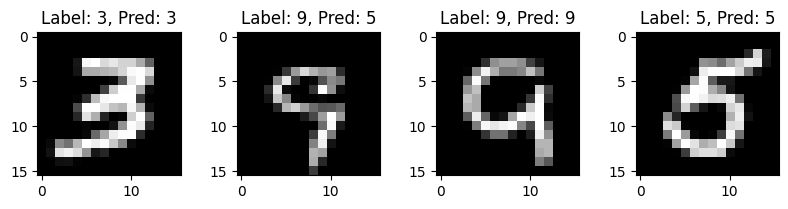

In [38]:
# ---- Predict and Visualize ----
with torch.no_grad():
    sample_idx = [0, 1, 2, 3]
    x_sample = x_test[sample_idx]
    y_true = [digits[i] for i in y_test[sample_idx]]
    logits = model(x_sample)
    preds = torch.argmax(logits, axis=1)
    y_pred = [digits[i] for i in preds]
    x_sample_imgs = x_sample.reshape(-1, n_px, n_px)
    visualize_data(x_sample_imgs, y_true, y_pred)

# Quantum Model - Amplitude Embedding

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import pennylane as qml
import matplotlib.pyplot as plt

In [24]:
# -------------------------------
# Dataset Preparation
# -------------------------------
def get_dataset(digits=[3, 5, 8, 9], n_px=16, train_size=10000, test_size=2000):
    mnist_train = datasets.MNIST(root='./data', train=True, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True)

    def prepare(data, targets, digits, size, n_px):
        mask = torch.zeros_like(targets, dtype=torch.bool)
        for d in digits:
            mask |= (targets == d)
        data_f = data[mask]
        targ_f = targets[mask]

        idx = torch.randperm(len(data_f))[:size]
        imgs = data_f[idx].unsqueeze(1).float() / 255.0
        imgs_resized = F.interpolate(imgs, size=(n_px, n_px), mode='bilinear', align_corners=False)
        labs = targ_f[idx]
        labs_mapped = torch.tensor([digits.index(int(l)) for l in labs])
        return imgs_resized, labs_mapped

    x_train, y_train = prepare(mnist_train.data, mnist_train.targets, digits, train_size, n_px)
    x_test, y_test = prepare(mnist_test.data, mnist_test.targets, digits, test_size, n_px)
    return (x_train, y_train), (x_test, y_test)

In [25]:
# -------------------------------
# Quantum Circuit
# -------------------------------
def create_quantum_layer(n_qubits=8, n_layers=32):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def qnode(inputs, weights):
        qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=False)
        # qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(w)) for w in range(4)]

    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    return qml.qnn.TorchLayer(qnode, weight_shapes)

In [26]:
# -------------------------------
# Hybrid Model
# -------------------------------
class QuantumHybridModel(nn.Module):
    def __init__(self, n_qubits, num_classes, quantum_layer, n_px):
        super().__init__()
        self.n_qubits = n_qubits
        # self.encoder = nn.Linear(n_px * n_px, n_qubits)  # reduce 256 → n_qubits
        self.q_layer = quantum_layer
        self.classifier = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten: [B, 256]
        x = x / x.norm(dim=1, keepdim=True)  # Normalize for amplitude embedding
        # x = self.encoder(x)
        x = self.q_layer(x)  # Output: [B, n_qubits]
        # x = F.layer_norm(x, x.shape)  # Optional normalization
        return self.classifier(x)  # Logits
        # return self.q_layer(x)  # Output: [B, n_classes] logits

In [27]:
# -------------------------------
# Training Utilities
# -------------------------------
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, correct = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(dim=1) == y).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


In [28]:
# -------------------------------
# Main
# -------------------------------
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
n_qubits = 6
n_classes = 4
batch_size = 100
epochs = 20
n_px = 8

# Load Data
digits = [3, 5, 8, 9]
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)
train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# Model
q_layer = create_quantum_layer(n_qubits=n_qubits, n_layers=32)
model = QuantumHybridModel(n_qubits=n_qubits, num_classes=n_classes, quantum_layer=q_layer, n_px=n_px).to(device)

# Training Setup
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
loss_fn = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, train_dl, optimizer, loss_fn, device)
    test_loss, test_acc = evaluate(model, test_dl, loss_fn, device)
    scheduler.step(test_loss)

    print(f"Epoch {epoch:3d} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x4 and 6x4)